In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# We'll need to update our path to import from Drive.
import sys
sys.path.append('/content/drive/MyDrive/procesados/')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
# from scipy.signal import butter, lfilter
from sklearn import decomposition

from sklearn.metrics import pairwise_distances



Bajo paquete para trabajar con EEG- Me permite ver la topografía


In [4]:
!pip install mne
import mne

     |████████████████████████████████| 6.9 MB 5.4 MB/s 


In [5]:
path = '/content/drive/MyDrive/procesados/'
filename = 'suj_8_bl_1.txt'

datos = pd.read_csv(path+filename, sep=',', header=None)
EEGdata = datos.to_numpy()
srate=128
ch    = EEGdata.shape[0]
samples = EEGdata.shape[1] 

print("Sampling rate: {:.2f} Hz".format(srate))
print("Data shape: {:d} samples x {:d} channels".format(EEGdata.shape[1], EEGdata.shape[0]))
print("Tiempo total : {:.2f} ".format(samples/srate))

Sampling rate: 128.00 Hz
Data shape: 7681 samples x 30 channels
Tiempo total : 60.01 


In [6]:
# De antes, creo que necesarias

# Montage 10-20
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Elijo canales que tengo
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Me quedo solo con los canales seleccionados
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Me quedo con las referencias desde dónde están ubicados los canales
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)


# Levanto y grafico los txt crudos

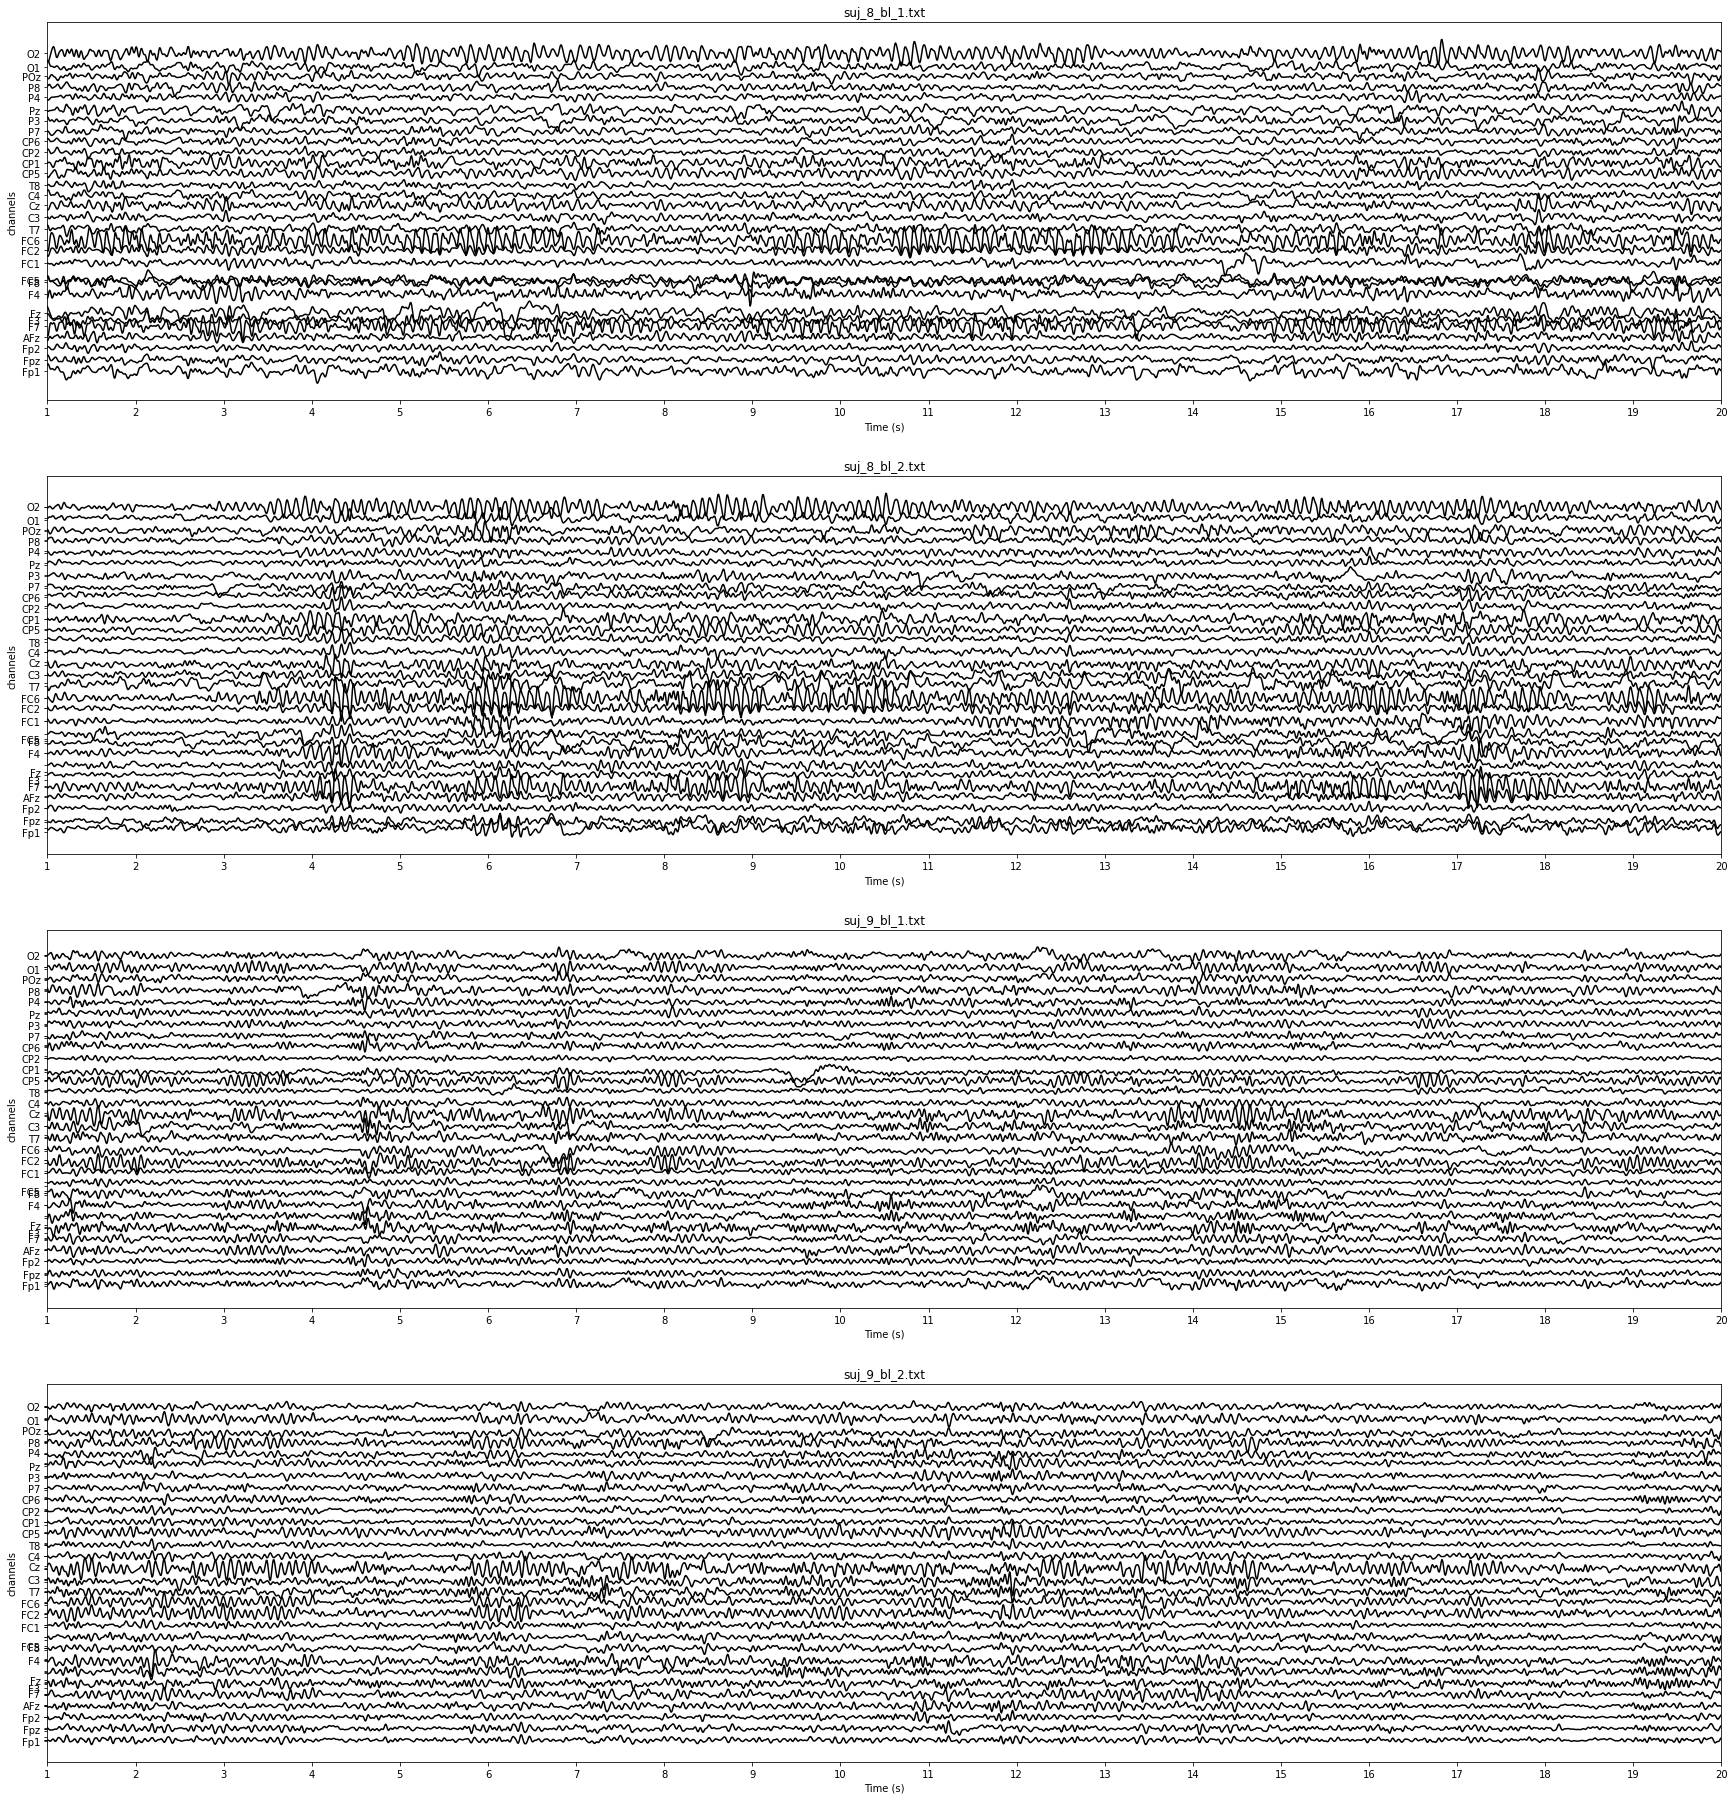

In [7]:
# Levanto y grafico los txt crudos

inicio = 1
fin    = 20
xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
#fig.suptitle('Series temporales (uV)')
yticks=[]

# filename = '/suj_8_bl_1.txt'
sujetos = [8,9]#,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

cant_graf = len(sujetos)*len(periodos)
alto_graf = cant_graf*8
fig, ax = plt.subplots(nrows=cant_graf, ncols=1,figsize=(30,alto_graf))

k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    EEGdata = datos.to_numpy()
    
    # for k,ax in enumerate(axes.flatten()):
    for c in np.arange(ch):
        temp = EEGdata[c,inicio*srate:fin*srate]
        dmin=np.min(temp)
        dmax=np.max(temp)
        vmedio = np.mean([dmin,dmax])+30*c
        yticks.append(vmedio)
        ax[j-1+k].plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'k')
    ax[j-1+k].set_xlim([inicio*srate,fin*srate])
    ax[j-1+k].set_xticks(xticks)
    ax[j-1+k].set_xticklabels(np.arange(inicio,fin+1))
    ax[j-1+k].set_yticks(yticks)
    ax[j-1+k].set_yticklabels(mont1020_30.ch_names)
    ax[j-1+k].set_ylabel('channels')
    ax[j-1+k].set_xlabel('Time (s)')
    ax[j-1+k].set_title(filename)
    # plt.show()

  k += 2  # porque cada sujeto tiene dos gráficos

# Promedios de las topografías, por sujeto y por período

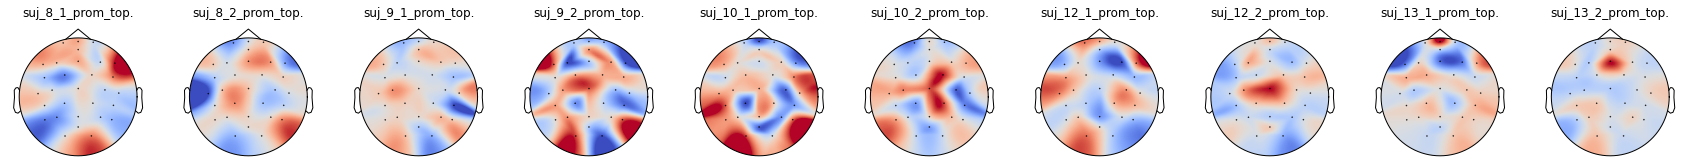

In [30]:
# Promedio de las topografías, por sujeto y por período

# inicio = 1
# fin    = 60
# xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
#fig.suptitle('Series temporales (uV)')
# yticks=[]

# filename = '/suj_8_bl_1.txt'
sujetos = [8,9,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

cant_graf = len(sujetos)*len(periodos)
# alto_graf = cant_graf*8
fig2, ax2 = plt.subplots(nrows=1, ncols=cant_graf, figsize=(30, 3), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

dic_toposProm ={}
k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    EEGdata = datos.to_numpy()
    
    EEGdata_meanTopografia = np.mean(EEGdata, axis=1)
    dic_toposProm['suj_'+f'{i}'+'_est_'+f'{j}'] = EEGdata_meanTopografia

    mne.viz.plot_topomap(EEGdata_meanTopografia,
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax2[j-1+k],show=False)
    ax2[j-1+k].set_title('suj_'+f'{i}_{j}'+'_prom_top.')  

  k += 2  # porque cada sujeto tiene dos gráficos


# Distancias entre topografías promedio

In [67]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

metrics = ['euclidean', 'manhattan', 'cosine', 'correlation'] # hay otras. Ver links anteriores.
# Obs: como son topografías promedio, las distancias coseno y correlation dan igual.
metric = metrics[2]
print(metric)
for i in sujetos:
  print('suj_'+f'{i}'+'_dist_entre_periodos: ', pairwise_distances([dic_toposProm['suj_'+f'{i}'+'_est_1']],[dic_toposProm['suj_'+f'{i}'+'_est_2']], metric=metric))

cosine
suj_8_dist_entre_periodos:  [[1.21476584]]
suj_9_dist_entre_periodos:  [[0.4822301]]
suj_10_dist_entre_periodos:  [[0.5935793]]
suj_12_dist_entre_periodos:  [[0.84494105]]
suj_13_dist_entre_periodos:  [[1.33842016]]


## PCA Con datos concatenados según período. Pre vs Post.

In [68]:
# PCA con datos concatenados a lo largo del tiempo, para todos los sujetos pre
# y todos los sujetos post.
 
# filename = '/suj_8_bl_1.txt'
sujetos = [8,9,10,12,13] # sujetos a graficar: 8,9,10,12,13
# periodos = [1] #hay solamente dos: 1, 2


all_subjects_pre = pd.DataFrame()
all_subjects_post = pd.DataFrame()
for i in sujetos:
  filename_pre = 'suj_'+f'{i}'+'_bl_'+'1'+'.txt'
  filename_post = 'suj_'+f'{i}'+'_bl_'+'2'+'.txt'
  datos_pre = pd.read_csv(path + filename_pre, sep = ',', header = None)
  datos_post = pd.read_csv(path + filename_post, sep = ',', header = None)
  all_subjects_pre = pd.concat([all_subjects_pre, datos_pre], axis = 1)# .to_numpy()
  all_subjects_post = pd.concat([all_subjects_post, datos_post], axis = 1)# .to_numpy()
  



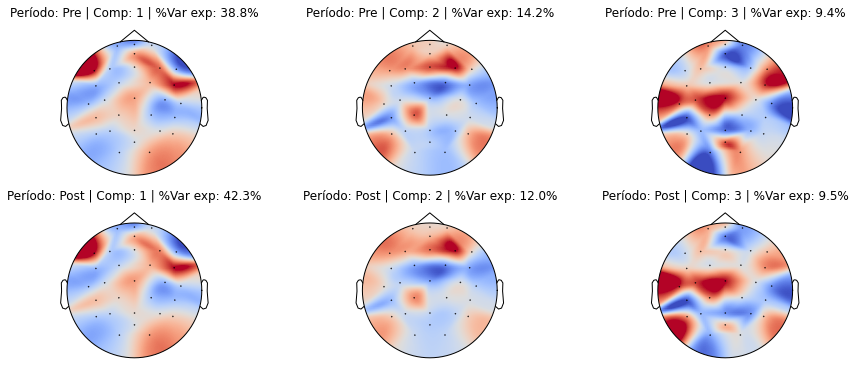

In [70]:
cant_comp = 3

cant_graf = 2
alto_graf = cant_graf * 3
fig3, ax3 = plt.subplots(nrows=cant_graf, ncols=cant_comp, figsize=(15, alto_graf), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)


pca_pre = decomposition.PCA(n_components=cant_comp)
pca_post = decomposition.PCA(n_components=cant_comp)

pca_pre.fit(all_subjects_pre)
pcs_pre = pd.DataFrame(pca_pre.transform(all_subjects_pre))
var_pre = pd.DataFrame(pca_pre.explained_variance_ratio_)

pca_post.fit(all_subjects_post)
pcs_post = pd.DataFrame(pca_post.transform(all_subjects_post))
var_post = pd.DataFrame(pca_post.explained_variance_ratio_)

pcs = pd.concat([pcs_pre, pcs_post], axis = 1)
var = pd.concat([var_pre, var_post], axis = 0, ignore_index = True)
labels = {0: 'Pre', 3: 'Post'}
k = 0
for i in (0,3):
  for p in range(cant_comp):
    mne.viz.plot_topomap(pcs.iloc[:,p+i],
                         info_eeg,
                         cmap='coolwarm', contours=0,
                         axes=ax3[k,p],show=False)
    ax3[k,p].set_title('Período: ' + f'{labels[i]}' + ' | Comp: ' + f'{p+1}' + ' | %Var exp: ' + str(round(var.iloc[i+p,0]*100,1)) + '%')  
  k += 1

# Distancias para cada PC entre períodos

In [80]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html#sklearn.metrics.pairwise_distances
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

metrics = ['euclidean', 'manhattan', 'cosine', 'correlation'] # hay otras. Ver links anteriores.
# Obs: como son topografías promedio, las distancias coseno y correlation dan igual.
metric = metrics[3]
print(metric)
for p in range(cant_comp):
  print('PC'+f'{p+1}'+'_dist_entre_periodos ', pairwise_distances([pcs_pre.iloc[:,p]],[pcs_post.iloc[:,p]], metric=metric))

correlation
PC1_dist_entre_periodos  [[0.00270225]]
PC2_dist_entre_periodos  [[0.02503441]]
PC3_dist_entre_periodos  [[0.07077661]]


# Referenciar datos el promedio

In [ ]:


# Datos referenciados a su promedio (de toda la señal en cada uno de los electrodos)


# filename = '/suj_8_bl_1.txt'
sujetos = [8,9]#,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

dic_datos_ref = {}

# k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    datos_mean = datos.mean(axis = 1)
    datos_std = datos.std(axis = 1)
    datos_ref = datos.sub(datos_mean.squeeze(), axis = 0)#.divide(datos_std, axis = 0 ) # zscore comentado

    key_name = 'suj_'+f'{i}'+'_est_'+f'{j}'
    dic_datos_ref[key_name] = datos_ref
    
    
dic_datos_ref["suj_8_est_1"]



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670,7671,7672,7673,7674,7675,7676,7677,7678,7679,7680
0,8.801913,12.523613,17.015613,19.207613,17.256613,11.789613,5.343113,0.590173,-1.253587,-0.722677,0.879293,2.708713,4.800313,7.439613,10.206613,11.687613,10.214613,5.095313,-2.670787,-10.797387,-16.908387,-19.668387,-19.144387,-16.348387,-12.539387,-8.847687,-6.244687,-5.509487,-6.932187,-9.947787,-13.208387,-15.301387,-15.694387,-15.081387,-14.667387,-14.886387,-14.704387,-12.298387,-6.762887,0.556833,...,4.480213,4.797113,6.219313,8.847013,11.409613,12.048613,9.654513,4.806713,-0.410927,-3.616687,-3.529287,-0.605707,3.475013,7.030213,9.323613,10.569613,11.142613,10.777613,8.572113,3.883213,-2.635187,-8.817587,-11.973387,-10.535387,-5.211387,1.260713,5.669113,6.161113,3.143613,-1.285987,-4.884187,-6.677187,-7.286487,-8.044587,-9.681587,-11.576387,-12.108387,-9.877987,-4.886387,1.130613
1,2.847463,4.257563,5.801963,4.893363,0.559713,-5.525537,-10.191637,-11.096637,-8.321937,-4.012837,-0.533867,1.269863,2.336463,4.140863,7.128763,10.157363,11.322363,9.404863,4.777463,-0.833477,-5.419837,-7.732037,-7.639837,-5.826137,-3.259937,-0.837937,0.750673,1.118363,0.309983,-1.169137,-2.584437,-3.396437,-3.544537,-3.290637,-2.737937,-1.509737,1.001763,4.911063,9.268263,12.279363,...,-2.806737,0.445103,3.454663,6.284963,8.442163,8.835663,6.524463,1.695563,-3.961437,-7.926837,-8.218737,-4.547637,1.517163,7.454163,11.138363,11.783363,10.016363,7.200963,4.586663,2.762963,1.635963,0.793423,-0.031392,-0.689017,-0.694167,0.380143,2.427063,4.591163,5.572263,4.383263,1.087163,-3.062237,-6.281637,-7.327937,-6.199937,-3.945537,-1.761637,-0.142207,1.200463,2.617363
2,8.461171,10.629271,9.062471,3.308071,-4.482729,-10.784729,-12.963729,-10.874729,-6.638429,-2.893229,-0.955319,-0.291469,0.470371,2.023571,3.699771,4.134571,2.583471,-0.331019,-3.062429,-4.331029,-4.005229,-2.949529,-2.086129,-1.592029,-0.944049,0.314441,1.904671,2.936071,2.713671,1.459071,0.220241,-0.003917,0.885881,2.070871,2.651171,2.557671,2.635871,3.753071,5.748271,7.272471,...,-5.870529,-0.904999,3.824271,8.209071,11.563271,12.487271,9.800871,3.766871,-3.517429,-9.079529,-10.793729,-8.624329,-4.500729,-0.964199,0.404881,-0.275859,-1.628229,-2.133329,-1.101529,1.051071,3.192871,4.155971,3.327571,0.950901,-1.926929,-3.883329,-3.836029,-1.728029,1.287971,3.450671,3.514971,1.651071,-0.605629,-1.435329,-0.090784,2.520771,4.519071,4.486571,2.520771,0.059769
3,1.406500,5.547200,4.786000,-0.101680,-5.506300,-7.673200,-5.370800,-0.541310,3.417700,4.269100,2.379100,-0.023046,-0.960380,-0.330440,0.296570,-0.583950,-2.746100,-4.164400,-2.678500,1.989200,7.614800,10.872400,9.716000,4.913300,-0.463000,-3.157400,-1.830900,2.370300,6.995500,10.088400,11.159400,10.797400,9.590900,7.498600,4.219000,0.056540,-3.723100,-5.560000,-4.786500,-2.244400,...,-8.139000,-6.674400,-4.022500,-0.373320,3.749200,7.420800,9.537400,9.269700,6.503000,1.978800,-2.976900,-7.016600,-9.320000,-9.837100,-9.122600,-7.872900,-6.445500,-4.667600,-2.082500,1.493200,5.470600,8.455000,8.849800,5.836700,0.130690,-6.064100,-10.021600,-9.893000,-5.701000,0.721370,6.788500,10.532400,11.409400,10.113400,7.694700,4.756700,1.327800,-2.622200,-6.586200,-9.439100
4,0.891551,-3.822989,-10.762789,-15.661789,-14.484789,-6.593789,4.271411,12.217211,13.167211,7.659111,0.319421,-3.599289,-2.004089,2.764211,6.045411,4.625111,-0.758629,-5.990789,-6.682589,-1.430089,7.103311,13.911211,14.852211,9.171711,-0.101794,-7.888389,-9.732289,-3.972389,7.538511,20.326211,29.320211,31.102211,25.369211,14.833211,3.528211,-5.480589,-11.532789,-15.942789,-20.051789,-23.346789,...,-8.627589,-11.707789,-13.208789,-12.983789,-10.189789,-4.022789,5.010711,14.436211,20.563211,20.402211,13.520211,2.502211,-8.378389,-15.439789,-17.340789,-15.181789,-11.0867

# GFP, picos, y guardar la señal en la posición de los picos

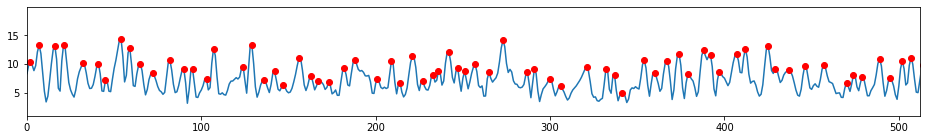

In [ ]:
# Calculo GFP

dic_gfp = {}
for key in dic_datos_ref.keys():
    dic_gfp[key] = dic_datos_ref[key].std(ddof=0) #ddof=0 es para que divida por N (divide por N-ddof)
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.std.html




# busco picos de GFP y guardo GFP en las posiciones de los picos

# busco picos de GFP
from scipy.signal import find_peaks 

dic_gfp_posPicos = {}
for key in dic_gfp.keys():
  peaks_pos, peaks_value = find_peaks(dic_gfp[key], prominence=0.8)
  dic_gfp_posPicos[key] = peaks_pos


# Guardo GFP y señales en las posiciones de los picos
dic_datos_ref_enPicos = {}
dic_gfp_enPicos = {}
for key in dic_gfp_posPicos.keys():
  peaks_pos = dic_gfp_posPicos[key]
  dic_gfp_enPicos[key] = dic_gfp[key][peaks_pos]
  dic_datos_ref_enPicos[key] = dic_datos_ref[key].iloc[:,peaks_pos]


# Grafico una parte para ver cómo van quedando los picos
inicio = 0
fin = 4
fig,ax=plt.subplots(ncols=1,figsize=(16,2))
key = 'suj_8_est_1'
ax.plot(dic_gfp[key])
ax.set_xlim([inicio*srate,fin*srate])
# peaks_pos = 
ax.plot(dic_gfp_posPicos[key],dic_gfp_enPicos[key],'ro')